## Paso 1: Efecto de tratamiento promedio (ATE)

Algo que dificulta la inferencia causal es el sesgo, pero este puede ser eliminado randomizando los datos gracias a la eliminación de variables confusas (llamado confounding).

Al randomizar los descuentos asignados, se logra aislar el efecto de los descuentos sobre las utilidades, y esto permite comparar clientes con descuentos altos con clientes con descuentos bajos, así al ver la diferencia en las utilidades puede ser atribuidas solamente al cambio en los descuentos, el comparar la diferencia promedio correspondiente a los descuentos entre la relación de datos randomizados con no randomizados se le llama *Efecto de tratamiento promedio* o Average Treatment Effect (ATE por sus siglas en inglés).

Se generará una pendiente del coeficiente de regresión al cual nos referiremos como efecto causal linear, con descuentos randomizados, estimar el ATE será sencillo.

In [117]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

train = pd.read_csv("./non_rand_discount.csv", sep=";")
test = pd.read_csv("./random_data.csv")

In [118]:
train["discount"] = train["discount"].str.split(" ").str[-1].astype(float)

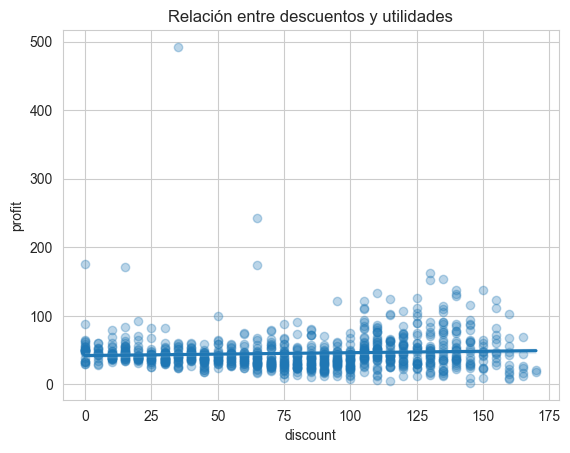

In [119]:
np.random.seed(123)
sns.regplot(data = train.sample(1000), x="discount", y="profit", scatter_kws={"alpha":0.3})
plt.title("Relación entre descuentos y utilidades");

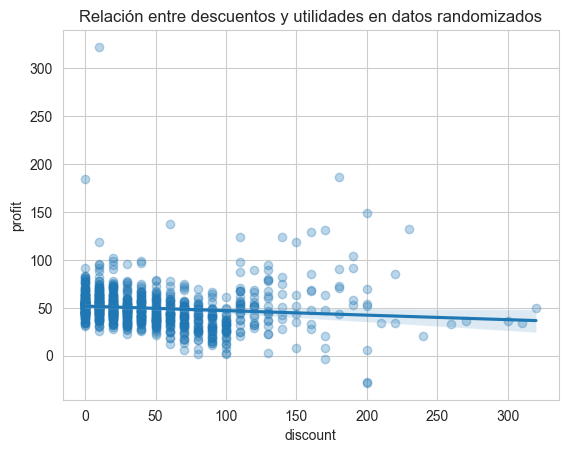

In [120]:
np.random.seed(123)
sns.regplot(data = test.sample(1000), x="discount", y="profit", scatter_kws={"alpha":0.3})
plt.title("Relación entre descuentos y utilidades en datos randomizados");

In [121]:
def elast(data, t, y):
    cov_matrix = np.cov(data[y], data[t])
    return cov_matrix[1, 0] / cov_matrix[1, 1]

In [122]:
print("ATE del descuento en ventas:", elast(test, "discount", "sales"))
print("ATE del descuento en utilidades:", elast(test, "discount", "profit"))

ATE del descuento en ventas: 19.28676541602874
ATE del descuento en utilidades: -0.03566112670736015


In [123]:
print("Relación entre descuento y ventas:", elast(train, "discount", "sales"))
print("Relación entre descuento y utilidades:", elast(train, "discount", "profit"))

Relación entre descuento y ventas: 21.924806313467577
Relación entre descuento y utilidades: 0.0743147500562718


In [124]:
smf.ols("profit~discount", data=test).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,51.3226,0.390,131.725,0.000,50.559,52.086
discount,-0.0357,0.006,-6.058,0.000,-0.047,-0.024


Al observar el coeficiente de regresión entre descuentos y ventas, muestra que una unidad de descuento incrementa las ventas, pero sabemos que las utilidades se presentan a partir de:

$$
Utilidad_i = Ventas_i * 5\% - Descuento_i
$$

Significa que para incrementar la utilidad, 1 unidad de descuento tiene que incrementar las ventas por más de 20 unidades ($1/0.05 = 20$) pero como eso no está ocurriendo, la aplicación de descuentos actuales no lleva a mejorar las ganancias.

## Paso 2: Aprendizaje automático para la personalización

Entrenamos un modelo de regresión para predecir las ventas usando rasgos de los compradores, quitamos rasgos el rasgo `cust_state` ya que no cambia en lo absoluto los resultados, pero si agiliza el desempeño de la regresión, de igual forma, quitamos `discount` porque ne teoría desconocemos que descuento otorgaremos a los compradores antes de hacer la predicción.


In [125]:
X = list(train.drop(columns=['sales', 'profit', "cust_state", "discount", "sales_prediction_bins", "sales_prediction"]).columns)
Y = "sales"

In [126]:
np.random.seed(123)
pred_m = LGBMRegressor(max_depth=3)
pred_m.fit(train[X], train[Y])

LGBMRegressor(max_depth=3)

In [127]:
train_pred = train.assign(prediction = pred_m.predict(train[X]))
test_pred = test.assign(prediction = pred_m.predict(test[X]))

print("Calificación de entrenamiento:", r2_score(train_pred["sales"], train_pred["prediction"]))
print("Calificación de prueba:", r2_score(test_pred["sales"], test_pred["prediction"]))

Calificación de entrenamiento: 0.8542367421768512
Calificación de prueba: 0.42184459036355626


In [128]:
sorted_by_pred_test = test_pred.sort_values("prediction", ascending=False)

sorted_by_pred_test[["prediction", "profit", "discount"]].head()

,prediction,profit,discount
2913,8410.140425,389.76,150.0
1736,7171.388857,295.87,300.0
646,6496.265942,322.49,10.0
4354,6404.367544,186.96,180.0
1689,6375.683350,165.58,180.0


In [129]:
print("CATE mayor 1k:", elast(sorted_by_pred_test.head(1000), "discount", "profit"))
print("CATE menor 1k:", elast(sorted_by_pred_test.tail(1000), "discount", "profit"))

CATE mayor 1k: -0.0963773624479449
CATE menor 1k: -0.2911120555122059


Si ordenamos los datos por predicción de ventas, tomamos los primeros 1000 compradores (los de mayor predicción) y estimamos su elasticidad, obtenemos aproximadamente -0.1, si tomamos los de menor predicción obtenemos aproximadamente -0.3, esto significa que, los descuentos *no son redituables* en ningún segmento definido por el orden de las predicciones de ventas, y que mientras mayor sea la predicción de ventas, menor afección tiene el descuento sobre la utilidad, o sea, mientras más baja sea la predicción de ventas, menos utilidad generará la venta (más pérdida).

## Paso 3: Evaluación de estrategias de personalización

Evaluaremos las estrategias para asegurarnos la buena calidad de nuestro método de personalización usando inferencia causal.

Evaluaremos 3 diferentes estrategias:
1. Predicción con ML
2. Inferencia causal usando el rasgo causal identificado mediante el efecto descuento-utilidad
3. Aleatoria

4. Aplicaremos los siguientes métodos de evaluación:
1. Efecto de tratamiento por banda
2. Efecto de tratamiento acumulativo
3. Ganancia acumulativa

In [130]:
test_pred["binary_discount"] = np.where(test_pred["discount"] > 30, 1, 0)

In [131]:
def te(df, t, y):
    return df.query(f"{t}==1")[y].mean() - df.query(f"{t}==0")[y].mean()

In [132]:
ate = te(test_pred, y="profit", t="binary_discount")
ate

-7.955100647304356

In [133]:
def te_by_segment(df, pred, t, y, segments=10):
    return (df
            .assign(**{f"{pred}_band":pd.qcut(df[pred], q=segments)}) # crea segmentos de cuantil
            .groupby(f"{pred}_band")
            .apply(lambda df: te(df, y=y, t=t))) # Estima el efecto de tratamiento de cada segmento

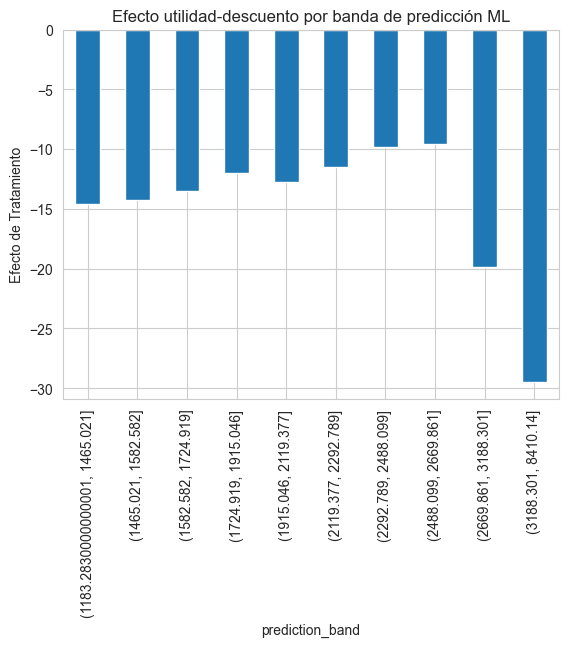

In [134]:
(te_by_segment(test_pred, "prediction", y="profit", t="binary_discount", segments=10)
 .plot.bar(title="Efecto utilidad-descuento por banda de predicción ML"))
plt.ylabel("Efecto de Tratamiento");

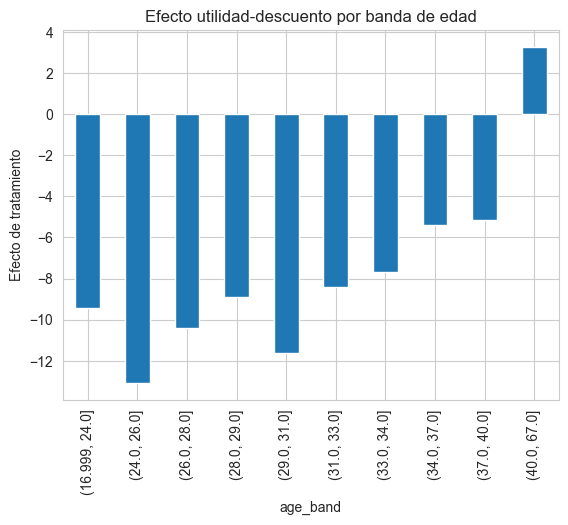

In [135]:
(te_by_segment(test_pred, "age", y="profit", t="binary_discount", segments=10)
 .plot.bar(title="Efecto utilidad-descuento por banda de edad"));
plt.ylabel(ylabel="Efecto de tratamiento");

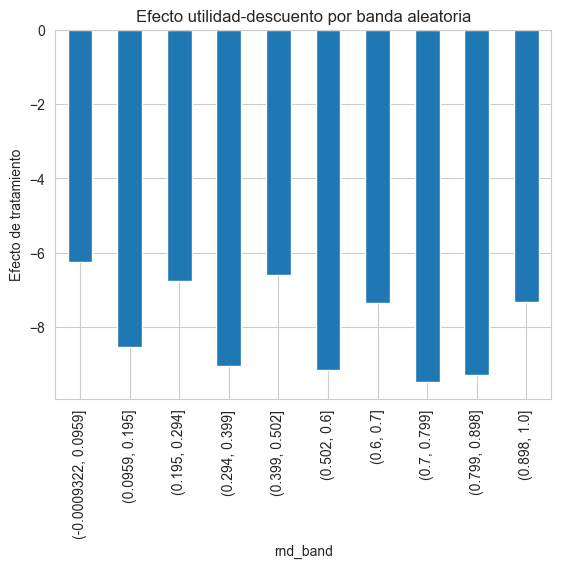

In [136]:
np.random.seed(123)
(te_by_segment(test_pred.assign(rnd=np.random.uniform(0,1,test.shape[0])),
               "rnd", y="profit", t="binary_discount", segments=10)
 .plot.bar(title="Efecto utilidad-descuento por banda aleatoria"))
plt.ylabel("Efecto de tratamiento");

En el efecto de tratamiento por banda mostrado, si segmentamos los compradores por nuestro modelo de predicción de ventas, podemos ver que no hay un segmento que si aplicaramos mayores descuentos nos lleva a mayor utilidad, ya que el efecto de tratamiento siempre es negativo.

Si vemos el segmento de edad, lo primero que se nota esque hay un segmento de edad donde los descuentos son redituables, si vemos le segmento de 40 a 67, el efecto de los descuentos resulta en el incremento de utilidad por 4, significa que si segmentamos los compradores por edad, encontraremos segmentos donde los descuentos producen ganancias, algo que no pudimos encontrar usando el modelo predictivo.

Finalmente, si segmentamos de forma aleatoria, se observa que el efecto de tratamiento varía alrededor del efecto de tratamiento promedio (ATE), el cual es alrededor de -8, esto es esperado, ya que el segmento definido de forma aleatoria se comporta de manera representativa como el conjunto de datos utilizados para generar el ATE.

In [137]:
def cumulative_elast_curve(dataset, prediction, y, t, steps=100, ascending=False):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=ascending).reset_index(drop=True)
    return np.array([te(ordered_df.query(f"index<={row}"), t=t, y=y)
                     for row in range(size//steps, size+1, size//steps)])


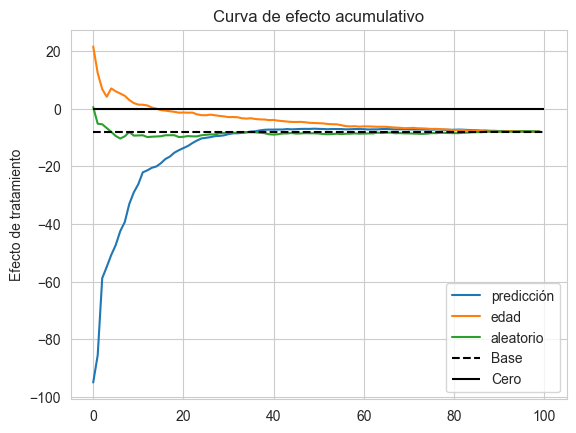

In [138]:
cum_effect_prediction = cumulative_elast_curve(test_pred, "prediction", y="profit", t="binary_discount")
cum_effect_age = cumulative_elast_curve(test_pred, "age", y="profit", t="binary_discount")
cum_effect_rnd = cumulative_elast_curve(test_pred.assign(rnd=np.random.uniform(0, 1, test.shape[0])),
                                    "rnd", y="profit", t="binary_discount")

plt.plot(cum_effect_prediction, label="predicción")
plt.plot(cum_effect_age, label="edad")
plt.plot(cum_effect_rnd, label="aleatorio")

plt.hlines(ate, 0, 100, linestyle="--", color="black", label="Base")
plt.hlines(0, 0, 100, linestyle="solid", color="black", label="Cero")
plt.ylabel("Efecto de tratamiento")
plt.title("Curva de efecto acumulativo")
plt.legend();

En el efecto de tratamiento acumulativo, vemos que la curva nos dice una historia similar a la observada anteriormente en el efecto por banda, ordenando los compradores por predicción de ventas siempre lleva un efecto de tratamiento negativo, pero si se observa por edad, se observa que 20% de los compradores mayores de edad tienen un efecto positivo en las utilidades al aplicar descuentos, indicando que segmentar los compradores por edad y enviar descuentos a los compradores más viejos es la mejor estrategia de personalización que utilizar un modelo predictivo de ML.

En la línea negra punteada, se muestra que el efecto de tratamineto promedio nos indica que sucedería si no se segmenta en lo absoluto, ya que está línea está bajo el cero, significa que en promedio sin personalización, los descuentos jamás serán redituables. De igual forma se nota que una segmentación aleatoria fluctúa alrededor del ATE como es esperado.


In [139]:
def cumulative_gain(dataset, prediction, y, t, steps=100, ascending=False):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=ascending).reset_index(drop=True)
    return np.array([te(ordered_df.query(f"index<={row}"), t=t, y=y)*row/size
                     for row in range(size//steps, size+1, size//steps)])


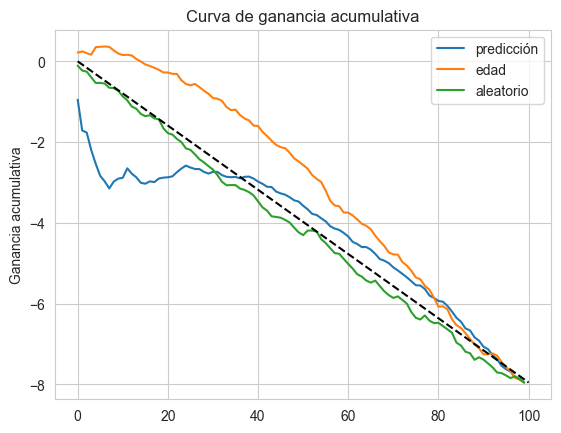

In [140]:
np.random.seed(123)

gain_prediction = cumulative_gain(test_pred, "prediction", y="profit", t="binary_discount")
gain_age = cumulative_gain(test_pred, "age", y="profit", t="binary_discount")
gain_rand = cumulative_gain(test_pred.assign(rand=np.random.uniform(0, 1, test.shape[0])),
                            "rand", y="profit", t="binary_discount")

plt.plot(gain_prediction, label="predicción")
plt.plot(gain_age, label="edad")
plt.plot(gain_rand, label="aleatorio")

plt.plot([0, 100], [0, ate], linestyle="--", color="black")


plt.ylabel("Ganancia acumulativa")
plt.title("Curva de ganancia acumulativa")
plt.legend();

Y finalmente, la ganancia acumulativa nos relata un similar resultado a los anteriores, esta curva es más difícil de interpretar, pero es la más conveniente para comparar las distintas estrategias, ya que mayor el punto de la curva en la parte superior izquierda, mejor es la estrategia de personalización, y se puede observar claramente que personalizar por edad es una mejor idea que personalizar con el modelo predictivo de ML o aleatorio que de igual manera fluctúa alrededor de la línea base (ATE).


## Paso 4: tratamiento continuo

En el paso anterior evaluamos la calidad de personalización utilizando un score, pero ahora utilizaremos los métodos de efecto de tratamiento por banda, efecto de tratamiento acumulativo y ganancia acumulativa para realizar un tratamiento continuo, esto significa que alimentaremos nuestras estrategias como entrada y obtendremos unas curvas de elasticidad económica que nos indicarán cuál es la estrategia de personalización más adecuada en brindarnos ganancias al aplicar descuentos.


In [141]:
def elast_by_segment(df, pred, y, t, segments=10):
    return (df
            .assign(**{f"{pred}_band":pd.qcut(df[pred], q=segments)}) # crea particiones cuantiles
            .groupby(f"{pred}_band")
            .apply(lambda df: elast(df, y=y, t=t))) # estima la elasticidad de cada partición

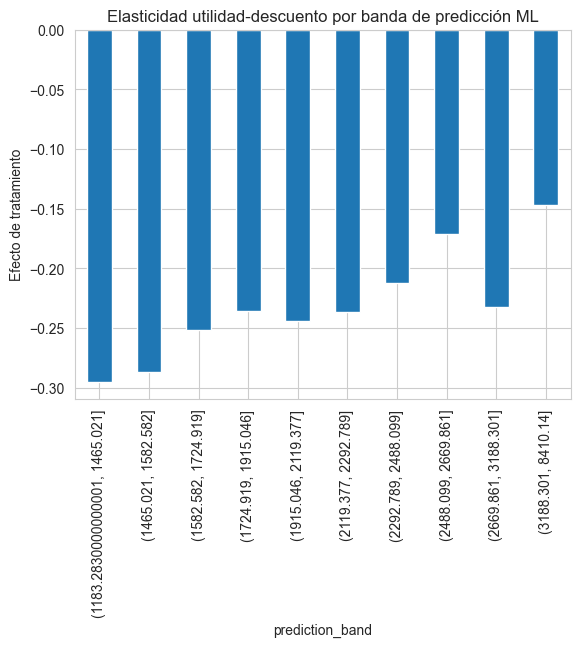

In [142]:
(elast_by_segment(test_pred, "prediction", y="profit", t="discount", segments=10)
 .plot.bar(title="Elasticidad utilidad-descuento por banda de predicción ML"))
plt.ylabel("Efecto de tratamiento");

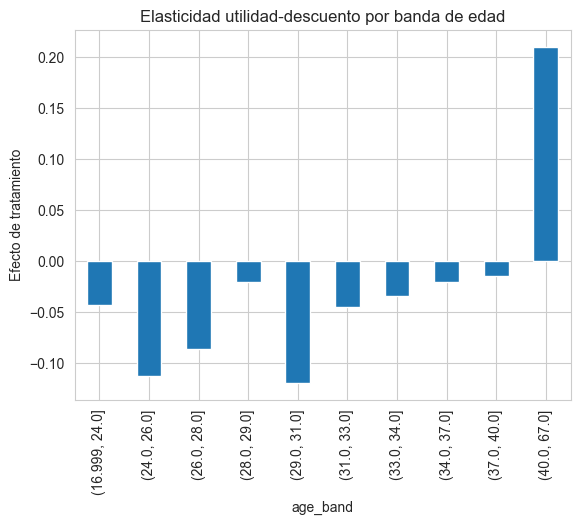

In [143]:
(elast_by_segment(test_pred, "age", y="profit", t="discount", segments=10)
 .plot.bar(title="Elasticidad utilidad-descuento por banda de edad"));
plt.ylabel(ylabel="Efecto de tratamiento");

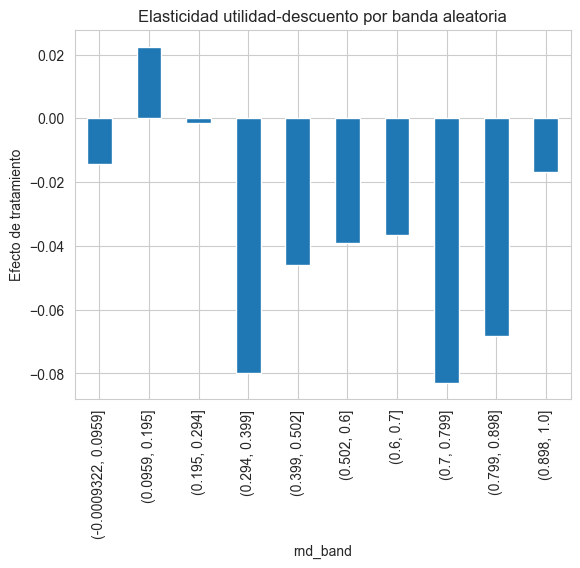

In [144]:
np.random.seed(123)
(elast_by_segment(test_pred.assign(rnd=np.random.uniform(0,1,test.shape[0])),
                  "rnd", y="profit", t="discount", segments=10)
 .plot.bar(title="Elasticidad utilidad-descuento por banda aleatoria"))
plt.ylabel("Efecto de tratamiento");

Si segmentamos los compradores por el modelo de predicción de ventas, de nuevo se muestra que los descuentos no llevan a obtener ganancias, lo cual valida lo observado en el paso 3 al aplicar la evaluación mediante el efecto de tratamiento por banda.
Ahora, si se observa el segmento de edad, se muestra positivo, llevando a obtener ganancias en la aplicación de los descuentos, lo cual valida de forma positiva la estrategia de personalización por edad comparando con la elasticidad utilidad-descuento en el tratamiento continuo, en el segmento 40 a 67, se obtiene un aumento de ganancia de \\\$0.2 por cada \\\$1.0 invertido como descuento, así que cada \\\$1 gastado generará \\\$1.2 en utilidad por ende, \\\$0.2 de ganancia.


In [145]:
def cumulative_elast_curve(dataset, prediction, y, t, steps=100, ascending=False):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=ascending).reset_index(drop=True)
    return np.array([elast(ordered_df.query(f"index<={row}"), t=t, y=y)
                     for row in range(size//steps, size+1, size//steps)])



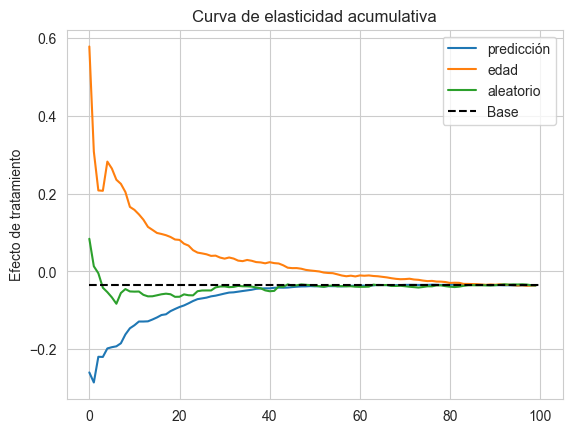

In [146]:
cum_elast_prediction = cumulative_elast_curve(test_pred, "prediction", y="profit", t="discount")
cum_elast_age = cumulative_elast_curve(test_pred, "age", y="profit", t="discount")
cum_elast_rnd = cumulative_elast_curve(test_pred.assign(rnd=np.random.uniform(0, 1, test.shape[0])),
                                       "rnd", y="profit", t="discount")

plt.plot(cum_elast_prediction, label="predicción")
plt.plot(cum_elast_age, label="edad")
plt.plot(cum_elast_rnd, label="aleatorio")

plt.hlines(elast(test_pred, "discount", "profit"), 0, 100, linestyle="--", color="black", label="Base")
plt.ylabel("Efecto de tratamiento")
plt.title("Curva de elasticidad acumulativa")
plt.legend();

La curva de elasticidad acumulativa nos dice algo similar a lo observado anteriormente, la predicción de ventas mediante ML siempre lleva a un efecto de tratamiento menor a cero, pero al observar la curva de edad, se observa que el 40% de los clientes más viejos tienen un efecto positivo sobre las ganancias en la aplicación de los descuentos.


In [147]:
def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100, ascending=False):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=ascending).reset_index(drop=True)
    return np.array([elast(ordered_df.query(f"index<={row}"), t=t, y=y) * (row/size)
                     for row in range(size//steps, size+1, size//steps)])


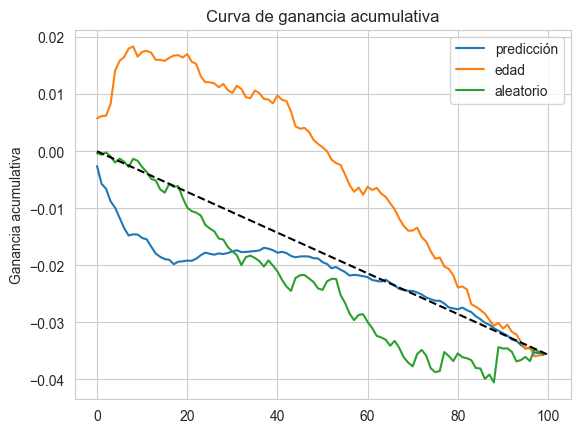

In [148]:
np.random.seed(123)
gain_prediction = cumulative_gain(test_pred, "prediction", y="profit", t="discount", ascending=False)
gain_age = cumulative_gain(test_pred, "age", y="profit", t="discount", ascending=False)
gain_rand = cumulative_gain(test_pred.assign(rand=np.random.uniform(0, 1, test.shape[0])),
                            "rand", y="profit", t="discount", ascending=False)

plt.plot(gain_prediction, label="predicción")
plt.plot(gain_age, label="edad")
plt.plot(gain_rand, label="aleatorio")

plt.plot([0, 100], [0, elast(test_pred, "discount", "profit")], linestyle="--", color="black")


plt.ylabel("Ganancia acumulativa")
plt.title("Curva de ganancia acumulativa")
plt.legend();

La curva de ganancia acumulativa mediante el tratamiento continuo nos indica lo mismo, la curva mayor en la esquina superior izquierda es la de edad, y la única arriba de cero, mostrando claramente que en el tratamiento continuo nos indica que personalizar los descuentos por edad es donde nos llevará a tener ganancias al aplicar descuentos.


## Paso 5: Aplicación del modelo causal para la personalización

Anteriormente, evaluamos las diferentes estrategias de personalización, les aplicamos un tratamiento continuo y validamos que la personalización utilizando inferencia causal con el rasgo causal identificado mediante el efecto descuento-utilidad es la mejor estrategia, y que dicho rasgo causal es la edad, generando ganancias aplicando los descuentos a los compradores entre los 40 y los 67 años de edad.

Ahora, generaremos el modelo causal para poder generar una calificación (score) que nos sirva para crear una personalización de descuentos de manera automática, esto lo haremos creando un modelo de heterogeneidad de efecto de tratamiento, evaluar dicho modelo usando los métodos aplicados anteriormente, y generar un score de recomendación según los datos de salida del modelo.

El modelo de heterogeneidad de efecto de tratamiento, de acuerdo a lo identificado anteriormente, se define como:

$$
TE_i = Modelo(testData_i,Descuento_i) − Modelo(testData,Descuento_i − 1)
$$

In [149]:
teh_model = smf.ols("profit~discount*(tenure+age+C(cust_state))", data=train).fit()

In [150]:
test_te = teh_model.predict(test) - teh_model.predict(test.assign(discount=test["discount"]-1))

test_pred["teh_model"] = test_te

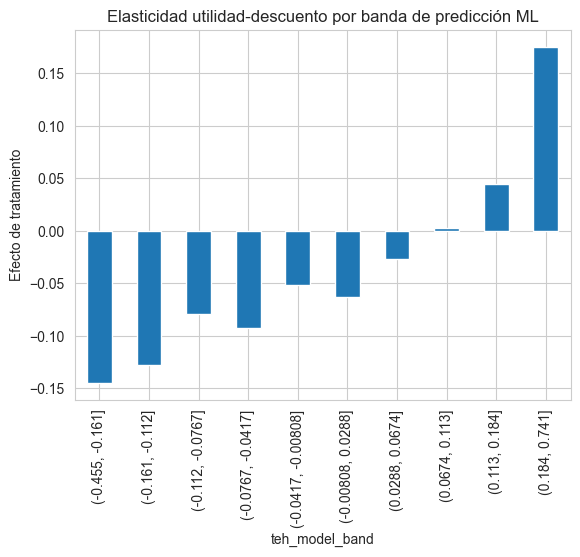

In [151]:
(elast_by_segment(test_pred, "teh_model", y="profit", t="discount", segments=10)
 .plot.bar(title="Elasticidad utilidad-descuento por banda de predicción ML"))
plt.ylabel("Efecto de tratamiento");

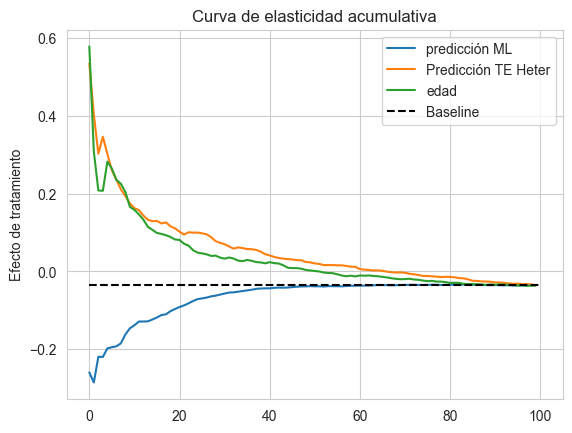

In [152]:
cum_elast_teh = cumulative_elast_curve(test_pred, "teh_model", y="profit", t="discount")

plt.plot(cum_elast_prediction, label="predicción ML")
plt.plot(cum_elast_teh, label="Predicción TE Heter")
plt.plot(cum_elast_age, label="edad")

plt.hlines(elast(test_pred, "discount", "profit"), 0, 100, linestyle="--", color="black", label="Baseline")
plt.ylabel("Efecto de tratamiento")
plt.title("Curva de elasticidad acumulativa")
plt.legend();

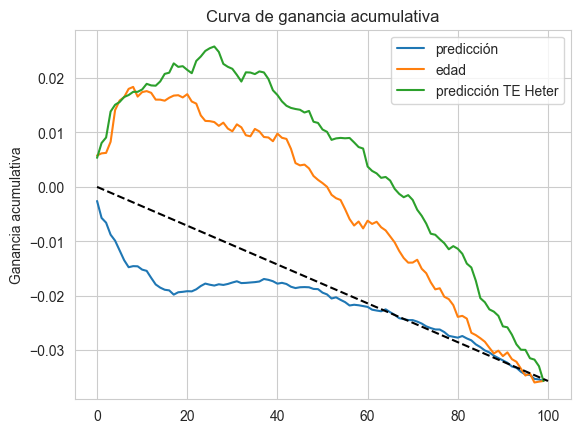

In [153]:
gain_teh = cumulative_gain(test_pred, "teh_model", y="profit", t="discount", ascending=False)

plt.plot(gain_prediction, label="predicción")
plt.plot(gain_age, label="edad")
plt.plot(gain_teh, label="predicción TE Heter")

plt.plot([0, 100], [0, elast(test_pred, "discount", "profit")], linestyle="--", color="black")

plt.ylabel("Ganancia acumulativa")
plt.title("Curva de ganancia acumulativa")
plt.legend();

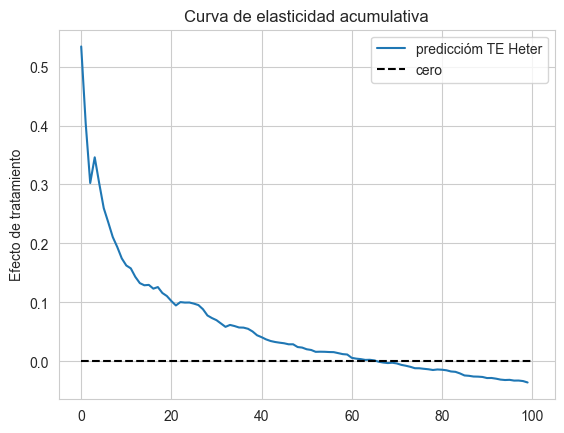

In [154]:
plt.plot(cum_elast_teh, label="prediccióm TE Heter")

plt.hlines(0, 0, 100, linestyle="--", color="black", label="cero")
plt.ylabel("Efecto de tratamiento")
plt.title("Curva de elasticidad acumulativa")
plt.legend();

Finalmente, la curva de la elasticidad acumulativa nos indica que, si ordenamos nuestros compradores de acuerdo a nuestro modelo de efecto de tratamiento, el 60& de los compradores arriba de cero tendrán un efecto de tratamiento positivo, significa que si aumentamos el descuento para ellos, también aumentarán nuestras ganancias, por lo que InsideSales recomendatría aplicar descuentos a cualquier comprador que tiene una predicción TE arriba del percentil 60